# Explore here

In [63]:
# Your code here
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import numpy as np 
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from prophet import Prophet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge



In [64]:
#Vizualisamos dataset: 
df = pd.read_csv('/workspaces/pauline-Serie-Temporal-Alternativa/data/raw/sales.csv')
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [65]:
df.dtypes

date      object
sales    float64
dtype: object

In [66]:
#Sales como float está bien, nos falta poner date en formato datime: 
df["date"] = pd.to_datetime(df.date)
df.dtypes

date     datetime64[ns]
sales           float64
dtype: object

In [67]:
#Hay 366 linea pues parece ser un df de numeros sobre un año, vamos a ver si es así, y que rango de fecha : 
 
#Fecha max y min : 
print(df.date.max())
print(df.date.min())
#Diferencia en días dentro de nuestro df : 
(df.date.max()-df.date.min()).days

2023-09-03 17:10:08.079328
2022-09-03 17:10:08.079328


365

In [68]:
df.date.nunique()

366

In [69]:
#Tensor = cada día a las 17h10 tenemos la nueva info sales. En ese df tenemos resultados de 1 año a partir del 03/09/22

#Hay 366 porque el 03/09 la tenemos 2 veces, en 22 y en 23, borro la de 2023 para tener exactamente analisis de 1 año:
df = df[df['date'] != pd.Timestamp('2023-09-03 17:10:08.079328')]
print(df.shape)




(365, 2)


In [70]:
#chequeamos igual si hay duplicados, a ver si nos faltaría una fecha : 
df.date.duplicated().sum() 

np.int64(0)

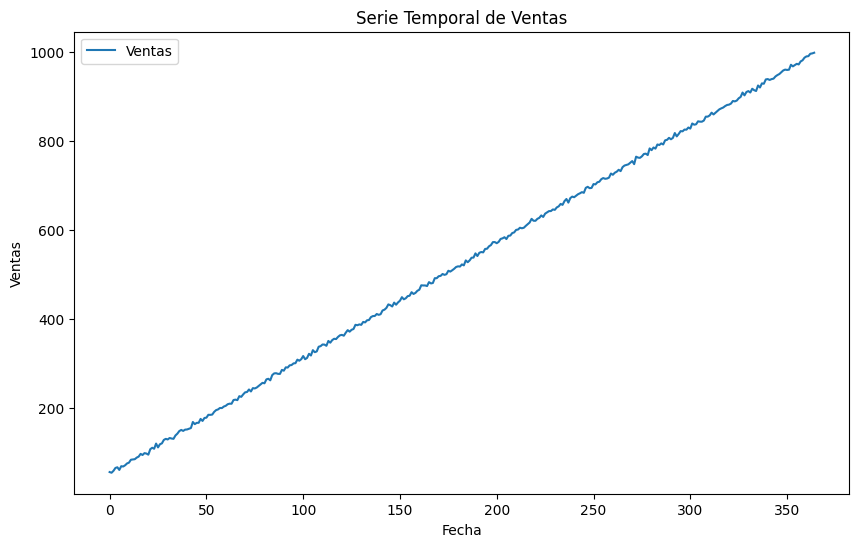

In [71]:
#Hacemos el gráfico :

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['sales'], label='Ventas')
plt.title('Serie Temporal de Ventas')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()




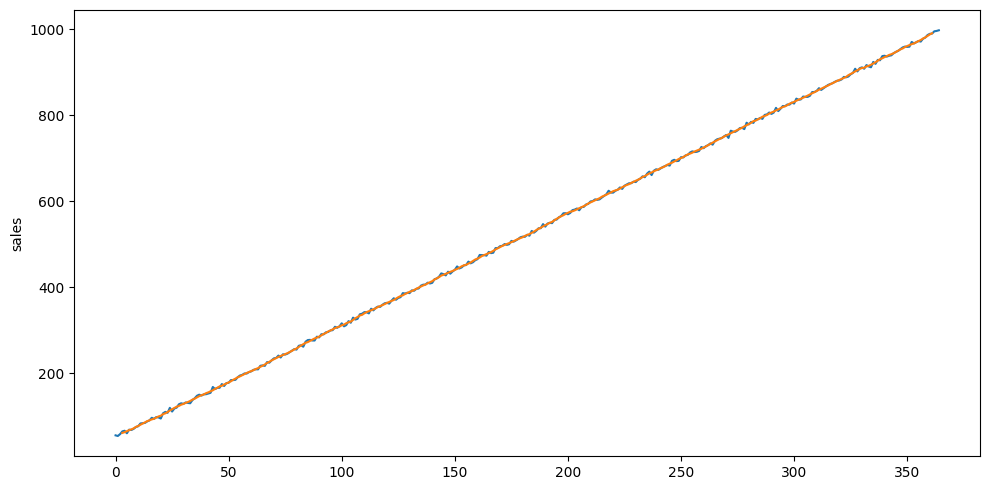

In [72]:
#Tendencia: vamos a verlo por semana: 

decomposition = seasonal_decompose(df['sales'], period=7)
decomposition

trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df['sales'])
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

[91, 182, 273, 365]


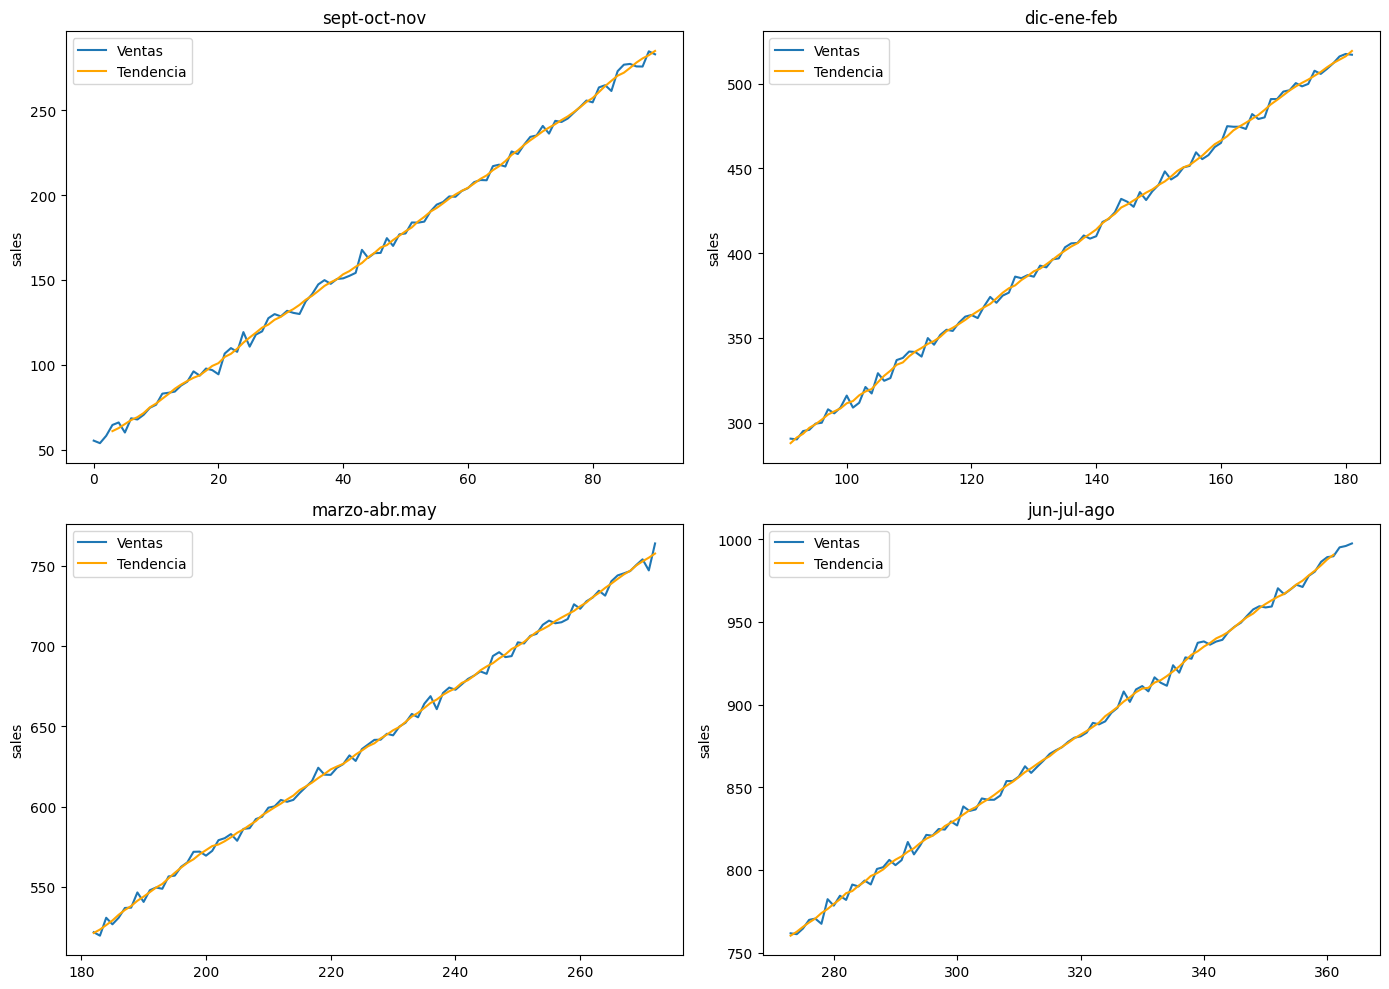

In [73]:
#No se ve muy bien pues voy a cortar en 4 subplots : 


#Definimos los cortes para los subgráficos (4 partes)
days_split = [91, 91, 91, 92]  #(=365 jours)


#Definimos los índices de los cortes de los periodos, dentro del df
indices = [sum(days_split[:i]) for i in range(1, 5)]
#chequeamo : 
print(indices)

#Subplots :
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

#Periodo 1:
sns.lineplot(data=df['sales'][:indices[0]], ax=axs[0, 0], label='Ventas')
sns.lineplot(data=trend[:indices[0]], ax=axs[0, 0], label='Tendencia', color='orange')
axs[0, 0].set_title('sept-oct-nov')
axs[0, 0].legend()

#Periodo 2:
sns.lineplot(data=df['sales'][indices[0]:indices[1]], ax=axs[0, 1], label='Ventas')
sns.lineplot(data=trend[indices[0]:indices[1]], ax=axs[0, 1], label='Tendencia', color='orange')
axs[0, 1].set_title('dic-ene-feb')
axs[0, 1].legend()

#Periodo 3
sns.lineplot(data=df['sales'][indices[1]:indices[2]], ax=axs[1, 0], label='Ventas')
sns.lineplot(data=trend[indices[1]:indices[2]], ax=axs[1, 0], label='Tendencia', color='orange')
axs[1, 0].set_title('marzo-abr.may')
axs[1, 0].legend()

#Periodo 4
sns.lineplot(data=df['sales'][indices[2]:], ax=axs[1, 1], label='Ventas')
sns.lineplot(data=trend[indices[2]:], ax=axs[1, 1], label='Tendencia', color='orange')
axs[1, 1].set_title('jun-jul-ago')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

Se observa una tendancia a la alza, la subida es bastante estable a lo largo del año, no se puede concluir que hay temporalidad.

In [74]:
#Ahora vamos a proceder a identificar test y train
#usaremos datos de los 9 primeros meses para train y 3 ultimos para test : para que el modelo aprenda de una cantidad representativa de datos, y luego se evalúe el periodo más reciente
df_train, df_test = df.iloc[:274], df.iloc[-91:]



In [75]:
df_train

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
269,2023-05-30 17:10:08.079328,750.429187
270,2023-05-31 17:10:08.079328,753.936865
271,2023-06-01 17:10:08.079328,747.024687
272,2023-06-02 17:10:08.079328,763.812942


In [76]:
n = 7 #7 días consecutivos, el modelo aprendea predecir el 7mo día utilizando los 6 días anteriores.
# X_train = [día 1, día 2, día 3, día 4, día 5, día 6], y
# y_train = día 7, a predecir 

XY_train = np.array([df_train.sales.values[i:i+n] for i in range(len(df_train.sales.values)) if len(df_train.sales.values[i:i+n])==n])
XY_test = np.array([df_test.sales.values[i:i+n] for i in range(len(df_test.sales.values)) if len(df_test.sales.values[i:i+n])==n])
X_train, y_train = XY_train[:,:-1], XY_train[:,-1] # Los primeros 6 días como características y el 7mo como etiqueta
X_test, y_test = XY_test[:,:-1], XY_test[:,-1]


In [83]:
# Crear el modelo de regresión lineal
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const)

# Ajustar el modelo a los datos
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.769e+05
Date:                Mon, 03 Mar 2025   Prob (F-statistic):               0.00
Time:                        10:32:58   Log-Likelihood:                -688.10
No. Observations:                 268   AIC:                             1390.
Df Residuals:                     261   BIC:                             1415.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9160      0.834     10.696      0.0

In [ ]:
#R2= 1 --> sobreajuste, predice perfectamente los datos de entrenamiento, pero no será efectivo con nuevos datos
#Vamos a hacer Ridge para intentar reducir el sobreajute : 


#Primero hay que hacer la predicción en el conjunto de test
X_test_const = sm.add_constant(X_test)
y_pred = results.predict(X_test_const)

#Calcular el MSE y MAE como metricas para comparar:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


#Crear y entrenar el modelo Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

#Predecir en el conjunto de test
y_pred_ridge = ridge_model.predict(X_test)

# Calcular las métricas de evaluación
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print(f'Ridge MSE: {mse_ridge}')
print(f'Ridge MAE: {mae_ridge}')


Mean Squared Error (MSE): 9.500678443978027
Mean Absolute Error (MAE): 2.473795934605965
Ridge MSE: 9.50068540403141
Ridge MAE: 2.4737903128791205


No ha funcionado, resultados casi iguales

In [79]:
#Probamos entonces como en clase con modelo KNRegresor: 

#Escalamos :
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

#Modelo :
modelo = KNeighborsRegressor().fit(X_train, y_train)
y_pred_train = modelo.predict(X_train)
y_pred_test = modelo.predict(X_test)
print(r2_score(y_train,y_pred_train), mean_absolute_percentage_error(y_train,y_pred_train)*100, mean_absolute_error(y_train,y_pred_train))
print(r2_score(y_test,y_pred_test), mean_absolute_percentage_error(y_test,y_pred_test)*100, mean_absolute_error(y_test,y_pred_test))

0.9997645296883981 0.8703435809914383 2.398278441974919
-4.353218666183042 14.482533243477269 132.47821055807242


R² cerca de 1, MAPE 0,87%, bajo --> igual aqui observamos sobreajuste ..

In [80]:
#aplicamos validación Walk Forward

def wf_validation(X_train , y_train, X_test , y_test):
  y_pred = []
  for i in range(len(y_test)):
    scaler = MinMaxScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    modelo = KNeighborsRegressor().fit(X_train_sc, y_train)
    y_pred.append(modelo.predict(np.array([X_test_sc[i]]))[0])
    X_train, y_train = np.vstack((X_train, X_test[i])), np.hstack((y_train, y_test[i]))
  return y_pred
y_pred = wf_validation(X_train , y_train, X_test , y_test)

print(r2_score(y_test,y_pred), mean_absolute_percentage_error(y_test,y_pred)*100, mean_absolute_error(y_test,y_pred))

0.9786199194354483 0.9550192854880306 8.381815174140854


R2 ha bajado un poco y MAPE subiendo también un poco, pero aun los resultados son demasiados buenos y surgieren un sobreajuste.

In [82]:
model_prophet = Prophet().fit(pd.DataFrame({'ds':df_train.date, 'y':df_train.sales.values}))
df_future = model_prophet.make_future_dataframe(periods=len(y_test), freq='d')

10:32:30 - cmdstanpy - INFO - Chain [1] start processing
10:32:30 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
df_future

,ds
0,2022-09-03 17:10:08.079328
1,2022-09-04 17:10:08.079328
2,2022-09-05 17:10:08.079328
3,2022-09-06 17:10:08.079328
4,2022-09-07 17:10:08.079328
...,...
354,2023-08-23 17:10:08.079328
355,2023-08-24 17:10:08.079328
356,2023-08-25 17:10:08.079328
357,2023-08-26 17:10:08.079328


In [85]:
forecast = model_prophet.predict(df_future)

In [86]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-09-03 17:10:08.079328,52.355787,49.805403,56.739233,52.355787,52.355787,0.767663,0.767663,0.767663,0.767663,0.767663,0.767663,0.0,0.0,0.0,53.123450
1,2022-09-04 17:10:08.079328,54.873169,52.104119,59.128088,54.873169,54.873169,0.759315,0.759315,0.759315,0.759315,0.759315,0.759315,0.0,0.0,0.0,55.632484
2,2022-09-05 17:10:08.079328,57.390551,54.677184,61.398295,57.390551,57.390551,0.811917,0.811917,0.811917,0.811917,0.811917,0.811917,0.0,0.0,0.0,58.202469
3,2022-09-06 17:10:08.079328,59.907933,56.120147,62.985906,59.907933,59.907933,-0.303884,-0.303884,-0.303884,-0.303884,-0.303884,-0.303884,0.0,0.0,0.0,59.604049
4,2022-09-07 17:10:08.079328,62.425315,58.739608,65.762575,62.425315,62.425315,-0.091274,-0.091274,-0.091274,-0.091274,-0.091274,-0.091274,0.0,0.0,0.0,62.334041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,2023-08-23 17:10:08.079328,968.972859,963.639213,974.244358,965.285961,972.618056,-0.091274,-0.091274,-0.091274,-0.091274,-0.091274,-0.091274,0.0,0.0,0.0,968.881585
355,2023-08-24 17:10:08.079328,971.558606,965.625330,976.286769,967.764078,975.264053,-0.612263,-0.612263,-0.612263,-0.612263,-0.612263,-0.612263,0.0,0.0,0.0,970.946343
356,2023-08-25 17:10:08.079328,974.144352,967.344712,978.152023,970.297870,977.937511,-1.331473,-1.331473,-1.331473,-1.331473,-1.331473,-1.331473,0.0,0.0,0.0,972.812879
357,2023-08-26 17:10:08.079328,976.730099,972.333560,982.929054,972.803869,980.584342,0.767663,0.767663,0.767663,0.767663,0.767663,0.767663,0.0,0.0,0.0,977.497761


In [87]:
yhat_test_pro = forecast.yhat[-len(y_test):]

In [88]:
print(r2_score(y_test,yhat_test_pro), mean_absolute_percentage_error(y_test,yhat_test_pro)*100, mean_absolute_error(y_test,yhat_test_pro))

0.9250177159068652 1.939563469646857 17.13916589653191


Disminuimos sobreajuste, R2 ha bajado y MAPE subido, con valors que siguen muy buenas, pero un poco más real que antes.

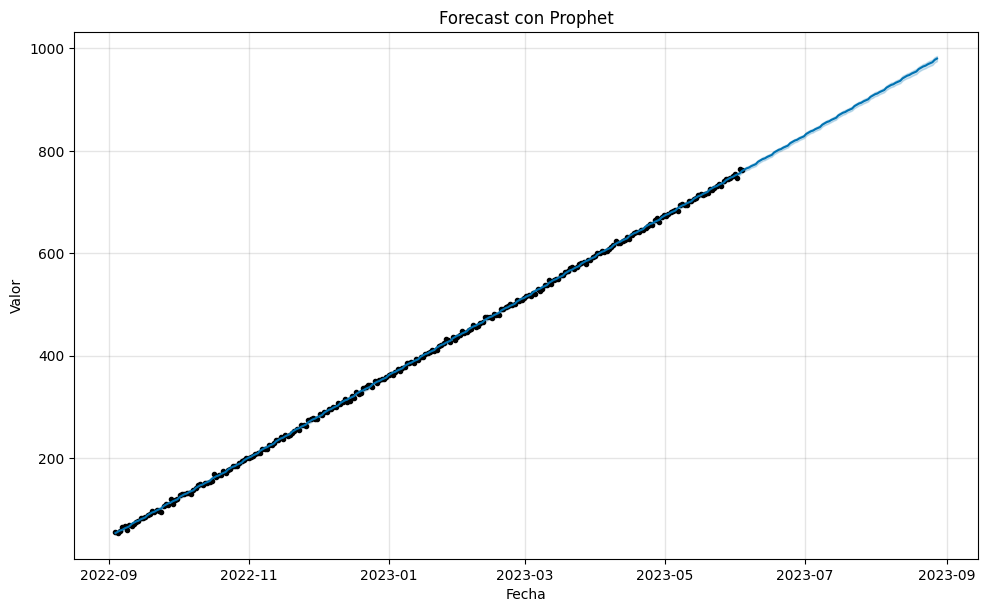

In [89]:
# Graficar el forecast
model_prophet.plot(forecast)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Forecast con Prophet')
plt.show()

La curva "future" es muy similar a la curva real que obtuvimos antes de separar test y train.

In [90]:
in_len, out_len = 7, 2
n = in_len+out_len
XY_train = np.array([df_train[i:i+n].sales.values for i in range(len(df_train)) if len(df_train[i:i+n])==n])
X_train , Y_train = XY_train[:,:in_len], XY_train[:,-out_len:]
XY_test = np.array([df_test[i:i+n].sales.values for i in range(len(df_test)) if len(df_test[i:i+n])==n])
X_test , Y_test = XY_test[:,:in_len], XY_test[:,-out_len:]

In [91]:
Y_test

array([[784.43038115, 781.8964532 ],
       [781.8964532 , 791.18447363],
       [791.18447363, 790.03711326],
       [790.03711326, 793.60735342],
       [793.60735342, 791.24780155],
       [791.24780155, 800.61973724],
       [800.61973724, 801.65849559],
       [801.65849559, 806.09731951],
       [806.09731951, 802.91025787],
       [802.91025787, 805.95417892],
       [805.95417892, 816.91175009],
       [816.91175009, 809.42269226],
       [809.42269226, 814.79763035],
       [814.79763035, 821.21889327],
       [821.21889327, 820.70413381],
       [820.70413381, 824.76255967],
       [824.76255967, 824.41809127],
       [824.41809127, 829.32934575],
       [829.32934575, 826.90233725],
       [826.90233725, 838.39904957],
       [838.39904957, 835.67290512],
       [835.67290512, 836.58960237],
       [836.58960237, 843.23202596],
       [843.23202596, 842.45345708],
       [842.45345708, 842.43558075],
       [842.43558075, 845.00094337],
       [845.00094337, 853.72515507],
 

In [92]:
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
#Multi : modelo de regresión a múltiples salidas al mismo tiempo

reg_multi = MultiOutputRegressor(KNeighborsRegressor()).fit(X_train_sc, Y_train)
ypred_test_multi = reg_multi.predict(X_test_sc)

In [94]:
ypred_test_multi

array([[752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
       [752.36105396, 755.38438139],
 

In [96]:
print(r2_score(Y_test,ypred_test_multi), mean_absolute_percentage_error(Y_test,ypred_test_multi)*100, mean_absolute_error(Y_test,ypred_test_multi))

-4.759637516492571 14.79847100500449 135.27179457092888


In [97]:
chain = RegressorChain(KNeighborsRegressor()).fit(X_train_sc, Y_train)
Ypred_test_chain = chain.predict(X_test_sc)

In [98]:
Ypred_test_chain

array([[752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
       [752.36105396, 752.36105396],
 

In [99]:
print(r2_score(Y_test,Ypred_test_chain), mean_absolute_percentage_error(Y_test,Ypred_test_chain)*100, mean_absolute_error(Y_test,Ypred_test_chain))

-4.866898367989263 14.969069563308029 136.78345828225855


R2 negativo, los modelos no funcionan, o me he faltado algo?? o no se puede medir MultioutputRegressor RegressorChain asi? 